In [ ]:
import pandas as pd
import re
import os
import string
from collections import Counter
import json
import numpy as np

import jieba
import gensim
from gensim import corpora
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
import pyLDAvis

from sentence_transformers import SentenceTransformer
import pymorphy3

import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing

In [9]:
def remove_latin_symbols(text): # убираем латиницу
    return re.sub(r'[a-zA-Zа-яА-Я0-9]', '', text)

def extract_chinese(text): # оставляем только китайские символы, включая знаки препинания!
    pattern = r'[\u4E00-\u9FFF]+'
    return ''.join(re.findall(pattern, text))

In [10]:
# стоп-слова
with open(r"D:\Studies\HSE\project\stopwords-zh.txt", "r", encoding="utf8") as doc:
	lines = doc.readlines()

stopwords = []

for line in lines:
	sw = line.strip()
	stopwords.append(sw)
	
stopwords = list(set(stopwords))
print(len(stopwords))
# print(stopwords)

1052


In [11]:
# именованные сущности
PER_PATH = r'D:\Studies\HSE\project\all_per.txt'
LOC_PATH = r'D:\Studies\HSE\project\all_loc.txt'
ORG_PATH = r'D:\Studies\HSE\project\all_org.txt'

def get_data_from_txt(file_path):
    with open(file_path, 'r', encoding='utf8') as file:
        return [line.strip() for line in file.readlines()]
    
per = get_data_from_txt(PER_PATH)
print(len(per))
loc = get_data_from_txt(LOC_PATH)
print(len(loc))
org = get_data_from_txt(ORG_PATH)
print(len(org))

named_entities = per + loc + org
print(len(named_entities))

12907
8701
3335
24943


In [12]:
# пунктуация
chinese_punctuation = "，。！？【】（）％＃＠＆、－《》“”‘’… · — ▔ '' 一一 ― .. □ xxxxx"
all_punctuation = string.punctuation + chinese_punctuation
all_punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~，。！？【】（）％＃＠＆、－《》“”‘’… · — ▔ \'\' 一一 ― .. □ xxxxx'

In [ ]:
# токенизация
folder_path_texts = r"D:\Studies\HSE\project\texts"
tokenized_docs = [] # считаем кол-во токенов
tokens_amount = []

for filename in os.listdir(folder_path_texts):
  # tokens = []

  with open(os.path.join(folder_path_texts, filename), "r", encoding="utf8") as file:
    text = file.read()
    words = list(jieba.cut(text.strip()))

    tokens_amount.append(len(words))
    tokenized_docs.append(words)

print(len(max(tokenized_docs, key=len)))
print(len(min(tokenized_docs, key=len)))

  # print(len(tokenized_docs))
  # print(len(max(tokenized_docs,  key=len)))

  #   filtered_text = remove_latin_symbols(text)
  #   filtered_text = extract_chinese(filtered_text)
  #   words = list(jieba.cut(filtered_text.strip()))
  #   # print(len(words))

  #   for word in words:
  #     word = word.strip()
  #     if word not in stopwords and word not in all_punctuation and word not in named_entities:
  #     # if word not in { *stopwords, *all_punctuation, *per, *loc, *org }:
  #       tokens.append(word)

  # tokenized_docs.append(tokens)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\soule\AppData\Local\Temp\jieba.cache
Loading model cost 0.553 seconds.
Prefix dict has been built successfully.


3917677
111173


In [6]:
total_length = sum(tokens_amount)
print(total_length)
avg_length = total_length / len(tokens_amount)
print(len(tokens_amount))
print(avg_length)

28622831
42
681495.9761904762


In [ ]:
# сохраняем токены в файл 
with open("all_tokens.txt", "w", encoding="utf-8") as f:
    json.dump(tokenized_docs, f, ensure_ascii=False)

In [ ]:
with open("all_tokens.txt", "r", encoding="utf-8") as f:
    tokenized_docs = json.load(f)

print(len(tokenized_docs))

42


In [7]:
flat_tokens = [x for xs in tokenized_docs for x in xs]
flat_tokens[:2]

['十一月', '末德']

In [8]:
if "魏无羡" in flat_tokens:
    print("True")
else:
    print("False")

False


In [8]:
# tokenized_docs[:1]

# PMI

In [ ]:
import math
import paddlehub as hub


d:\Studies\HSE\project\.venv\Lib\site-packages\paddle\utils\cpp_extension\extension_utils.py:711: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
d:\Studies\HSE\project\.venv\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
d:\Studies\HSE\project\.venv\Lib\site-packages\paddlenlp\server\http_router\router.py:30: PydanticDeprecatedSince20: `pydantic.config.Extra` is deprecated, use literal values instead (e.g. `extra='allow'`). Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  class RequestBase(BaseModel, extra=Extra.forbid):
d:\Studies\HSE\project\.venv\Lib\site-packages\paddlehub\compat\module\module_desc_pb2.py:17: Deprec

In [ ]:
def generate_ngrams(tokens, n):
    """Генерация n-грамм из списка иероглифов"""
    characters = list("".join(tokens))  # бьем слова на иероглифы, а не ТОКЕНЫ!
    return [tuple(characters[i:i+n]) for i in range(len(characters) - n + 1)]

def compute_pmi(tokens, n, min_freq=5):
    """Вычисление PMI для n-грамм, сформированных из иероглифов"""
    # tokens = tokenize_text(corpus)
    total_tokens = len("".join(tokens))  
    
    # считаем частотность n-грамм
    unigram_counts = Counter("".join(tokens))  # отдельные иероглифы
    ngram_counts = Counter(generate_ngrams(tokens, n)) # n-граммы
    
    pmi_scores = {}
    
    for ngram, ngram_freq in ngram_counts.items():
        if ngram_freq < min_freq:
            continue
        
        lower_order_prob = math.prod([unigram_counts[ngram[i]] / total_tokens for i in range(n)])
        ngram_prob = ngram_freq / (total_tokens - n + 1)
        
        pmi = math.log2(ngram_prob / lower_order_prob)
        pmi_scores[ngram] = pmi
    
    # сортируем по убыванию 
    return sorted(pmi_scores.items(), key=lambda x: x[1], reverse=True)

In [ ]:
bigramms = []
threegramms = []
fourgramms = []
fivegramms = []

# топ-10 биграмм 
print("\nТоп-10 биграмм:")
bigram_pmi = compute_pmi(flat_tokens, 2)
for ngram, score in bigram_pmi[:50]:
    ngram_printed = ''.join(ngram)
    print(f"{ngram_printed}: {score:.4f}")
    bigramms.append(ngram_printed)

# топ-10 триграмм 
print("\nТоп-10 триграмм:")
trigram_pmi = compute_pmi(flat_tokens, 3)
for ngram, score in trigram_pmi[:50]:
    ngram_printed = ''.join(ngram)
    print(f"{ngram_printed}: {score:.4f}")
    threegramms.append(ngram_printed)

# топ-10 четырехграмм 
print("\nТоп-10 четырехграмм:")
fourgram_pmi = compute_pmi(flat_tokens, 4)
for ngram, score in fourgram_pmi[:50]:
    ngram_printed = ''.join(ngram)
    print(f"{ngram_printed}: {score:.4f}")
    fourgramms.append(ngram_printed)

# топ-10 пятиграмм 
print("\nТоп-10 пятиграмм:")
fivegram_pmi = compute_pmi(flat_tokens, 5)
for ngram, score in fivegram_pmi[:50]:
    ngram_printed = ''.join(ngram)
    print(f"{ngram_printed}: {score:.4f}")
    fivegramms.append(ngram_printed)


Топ-10 биграмм:


NameError: name 'flat_tokens' is not defined

In [ ]:
# посмотрим, пересекаются ли новые списки с изначально полученными NE
# все, кроме биграмм, да
common_elements = list(set(fivegramms) & set(named_entities))
print(common_elements)  

[]


In [ ]:
# тест
# модель не для чистого NER, это лексический анализатор, поэтому другие теги
lac = hub.Module(name="lac")

# анализируем с LAC
results = lac.cut(fivegramms, use_gpu=False)
for result in results:
    words = result['word']  # достаем слова
    tags = result['tag']  # достаем теги

    print(f"Слова: {words}")
    print(f"Теги: {tags}")
    print("-" * 30)

{'tag': ['nz'], 'word': ['吁嚱噫吁嚱']}
{'tag': ['nr'], 'word': ['锃锃锃锃锃']}
{'tag': ['nr', 'v', 'v'], 'word': ['岸花開', '蔠', '傷']}
{'tag': ['nz', 'v'], 'word': ['噫吁嚱', '噫吁']}
{'tag': ['PER', 'v'], 'word': ['花開蔠', '傷赏']}
{'tag': ['ns', 'n'], 'word': ['鹈鹕湾', '监狱']}
{'tag': ['nz'], 'word': ['甲基苯丙胺']}
{'tag': ['xc', 'xc', 'xc', 'xc', 'xc'], 'word': ['咣', '咣', '咣', '咣', '咣']}
{'tag': ['nz', 'v', 'n'], 'word': ['豌豆', '炖', '羔羊']}
{'tag': ['nr', 'v'], 'word': ['彼岸花開', '蔠']}
{'tag': ['w', 'w', 'w', 'w', 'w'], 'word': ['※', '※', '※', '※', '※']}
{'tag': ['a', 'nz', 'v', 'n'], 'word': ['嫩', '豌豆', '炖', '羔']}
{'tag': ['v', 'a'], 'word': ['螳螂捕蝉', '黄']}
{'tag': ['xc', 'xc', 'xc', 'xc', 'xc'], 'word': ['嗒', '嗒', '嗒', '嗒', '嗒']}
{'tag': ['nz', 'v'], 'word': ['蚍蜉撼树', '谈']}
{'tag': ['nr'], 'word': ['赳赳气昂昂']}
{'tag': ['a', 'n'], 'word': ['淅淅沥沥', '雨']}
{'tag': ['v', 'nr'], 'word': ['租赁', '莱曼诺']}
{'tag': ['nz', 'v'], 'word': ['咿咿呀呀', '唱']}
{'tag': ['nz'], 'word': ['二乙酰吗啡']}
{'tag': ['xc', 'xc', 'v'], 'word': ['叽叽', 

In [ ]:
# проверяем, что внутри words и tags
print("Тип слов:", type(words))
print("Пример слов", words[:5])
print("Тип тегов:", type(tags))
print("Пример тегов:", tags[:5])

Тип words: <class 'list'>
Пример данных words: ['祜禄氏']
Тип tags: <class 'list'>
Пример данных tags: ['PER']


In [ ]:
# инициализируем лексический анализатор
lac = hub.Module(name="lac")

def extract_tagged_words(ngrams_list, target_tags={"LOC", "ns", "s"}, use_gpu=False):
    """Анализирует список n-грамм с помощью LAC и извлекает слова с нужными тегами."""
    results = lac.cut(ngrams_list, use_gpu=use_gpu)

    all_words = []
    all_tags = []

    for result in results:
        all_words.extend(result["word"])  # добавляем все слова
        all_tags.extend(result["tag"])  # добавляем все теги
    print(all_words)
    unique_tags = set(all_tags)
    print("Все уникальные теги:", unique_tags)

    # фильтруем слова по заданным тегам
    filtered_words = [word for word, tag in zip(all_words, all_tags) if tag in target_tags]

    print("Выбранные слова:", filtered_words)
    return filtered_words

bigram_words = extract_tagged_words(bigramms)
trigram_words = extract_tagged_words(threegramms)
fourgram_words = extract_tagged_words(fourgramms)
fivegram_words = extract_tagged_words(fivegramms)

['砗磲', '雩琈', '蝌蚪', '沆瀣', '開蔠', '蔠', '傷', '倥偬', '鹈鹕', '↖', '↗', '梼杌', '鞑靼', '耄耋', '圭臬', '徜徉', '莨菪', '蝜蝂', '秸秆', '菡萏', '褡裢', '蜈蚣', '琤琤', '觳觫', '踯躅', '峳峳', '酩酊', '忸怩', '妯娌', '捯饬', '峥嵘', '橄榄', '玳瑁', '伉俪', '咭咭', '蛤蟆', '苜蓿', '蟋蟀', 'з', '∠', '赳赳', '蝈蝈', '蜉蝣', '葳蕤', '夶夶', '橐橐', '蚍蜉', '貔貅', '蹁跹', '囹圄', '馄饨', '凫茈', '鹌鹑']
Все уникальные теги: {'a', 'ORG', 'nz', 'nr', 'n', 'w', 'xc', 'v', 'PER'}
Выбранные слова: []
['開', '蔠', '傷', '琤琤琤', '莨菪碱', '鹈鹕湾', '癞蛤蟆', '苯丙胺', '茕茕孑', '_', '_', '_', '莺呖呖', '钮祜禄', '凫茈', '镯', '蚍蜉撼', '噌噌噌', '咯咭咭', '乒', '乒乓', '榛榛莽', '姚熹芙', '东莨菪', '噫吁嚱', '蔠', '傷赏', '嗞嗞嗞', '锃锃锃', '魅魍魉', '雄赳赳', '乙酰', '吗', '枇杷膏', '莺莺呖', '魑魅魍', '醍醐灌', '吁嚱噫', '嚱噫吁', '哦', '哦', '哦', '鹦鹉螺', '橄榄枝', '乒乓', '乓', '袅婷婷', '窸窸窣', '窸窣窣', '苏筱岚', '熙攘攘', '熙熙攘', '铛铛铛', '陷', '囹圄', '窈窕淑', '衫褴褛', '花開蔠', '淅淅沥', '淅沥沥', '菡萏院', '祜禄氏']
Все уникальные теги: {'a', 'nz', 'ns', 'nr', 'n', 'w', 'xc', 'v', 'PER'}
Выбранные слова: ['鹈鹕湾']
['琤琤琤琤', '_', '_', '_', '_', '開蔠', '傷赏', '嚱噫吁嚱', '花開', '蔠', '傷', '莺莺呖呖', '东莨菪碱', '魑魅魍魉', '噫吁嚱噫',

In [ ]:
# по очереди расширяем все исходные списки с именованными сущностями
loc.extend(bigram_words)
loc.extend(trigram_words)
loc.extend(fourgram_words)
loc.extend(fivegram_words)

len(loc)

8701

In [ ]:
# сохраняем, перезаписывая
with open("all_loc.txt", 'w', encoding='utf8') as f:
    for line in loc:
        f.write(f"{line}\n")

# LDA

In [6]:
# присваиваем словам индекс
dictionary = corpora.Dictionary(tokenized_docs)
# no_below "не меньше чем в n док-тах", no_above "не больше чем в n док-тах" 
dictionary.filter_extremes(no_below=5, no_above=0.4)

In [7]:
# bag of words
doc_term_matrix = [dictionary.doc2bow(doc) for doc in tokenized_docs]

In [13]:
doc_term_matrix

[[(0, 4),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 4),
  (5, 2),
  (6, 1),
  (7, 1),
  (8, 2),
  (9, 1),
  (10, 1),
  (11, 5),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 3),
  (17, 1),
  (18, 2),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 2),
  (27, 1),
  (28, 1),
  (29, 4),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 4),
  (36, 1),
  (37, 3),
  (38, 20),
  (39, 2),
  (40, 1),
  (41, 3),
  (42, 1),
  (43, 1),
  (44, 16),
  (45, 2),
  (46, 4),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 2),
  (58, 3),
  (59, 2),
  (60, 5),
  (61, 1),
  (62, 1),
  (63, 3),
  (64, 1),
  (65, 1),
  (66, 11),
  (67, 1),
  (68, 6),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 7),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 10),
  (82, 2),
  (83, 2),
  (84, 7),
  (85, 2),
  (86, 1),
  (87, 2),
  (88, 1),
  (89, 1),
  (90, 1),
  (91

In [18]:
# проверяем, какие остались частотные слова
word_counts = Counter([word for doc in tokenized_docs for word in doc])
print(word_counts.most_common(10))

[('死', 13932), ('说话', 11639), ('目光', 11575), ('时间', 10598), ('自然', 10262), ('脸', 9245), ('喜欢', 8997), ('脸上', 8982), ('准备', 8132), ('拜托', 8004)]


In [14]:
print(f"Количество документов: {len(tokenized_docs)}")
print(f"Количество уникальных слов (после очистки): {len(dictionary)}")

Количество документов: 42
Количество уникальных слов (после очистки): 40722


## Поиск оптимальных значений

Тем: 8, когерентность: 0.4642
Тем: 10, когерентность: 0.5281
Тем: 12, когерентность: 0.4853
Тем: 14, когерентность: 0.4199
Тем: 16, когерентность: 0.4963


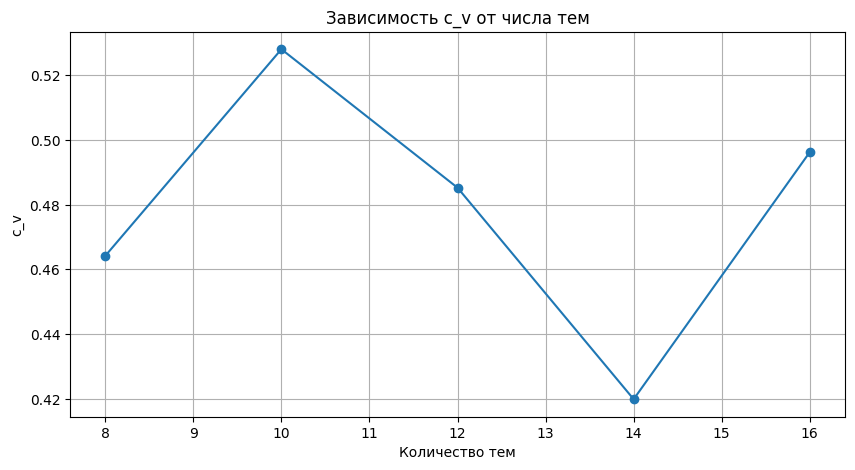

In [ ]:
# проверяем когерентность по c_v
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel

topics_range = range(8, 18, 2)

coherences = []

for k in topics_range:
    lda_model = LdaMulticore(
        corpus=doc_term_matrix,
        id2word=dictionary,
        num_topics=k,
        passes=10,
        workers=2,
        random_state=100,
    )

    coherence_model = CoherenceModel(
        model=lda_model,
        texts=tokenized_docs,  # используем НАШИ токенизированные тексты
        dictionary=dictionary,
        coherence='c_v'
    )

    coherence_score = coherence_model.get_coherence()
    coherences.append(coherence_score)
    print(f"Тем: {k}, когерентность: {coherence_score:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(topics_range, coherences, marker='o')
plt.xlabel("Количество тем")
plt.ylabel("c_v")
plt.title("Зависимость c_v от числа тем")
plt.grid()
plt.show()

Обучение LDA модели с 8 темами...
k = 8 => c_npmi: -0.1453
Обучение LDA модели с 10 темами...
k = 10 => c_npmi: -0.0843
Обучение LDA модели с 12 темами...
k = 12 => c_npmi: -0.1318
Обучение LDA модели с 14 темами...
k = 14 => c_npmi: -0.1411
Обучение LDA модели с 16 темами...
k = 16 => c_npmi: -0.1059

Результаты по числам тем:
8 тем: c_npmi = -0.1453
10 тем: c_npmi = -0.0843
12 тем: c_npmi = -0.1318
14 тем: c_npmi = -0.1411
16 тем: c_npmi = -0.1059


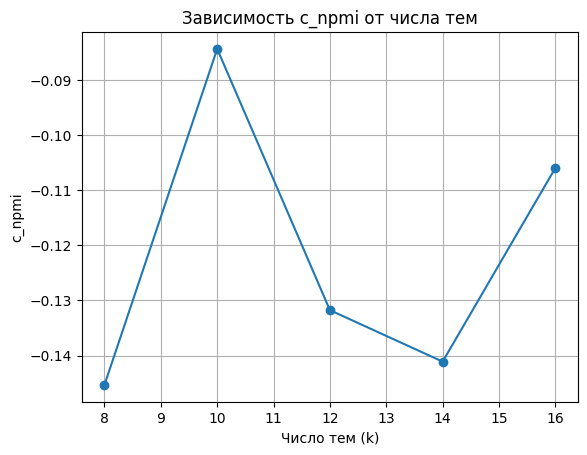

In [ ]:
# проверяем когерентность по c_npmi

topic_range = range(8, 18, 2)
npmi_scores = []

for k in topic_range:
    print(f"Обучение LDA модели с {k} темами...")
    lda_model = LdaMulticore(
        corpus=doc_term_matrix,
        id2word=dictionary,
        num_topics=k,
        random_state=100,
        passes=10,
        workers=2  
    )
    
    coherence_model_npmi = CoherenceModel(
        model=lda_model,
        texts=tokenized_docs,
        dictionary=dictionary,
        coherence='c_npmi'
    )
    npmi = coherence_model_npmi.get_coherence()
    npmi_scores.append(npmi)
    print(f"k = {k} => c_npmi: {npmi:.4f}")

print("\nРезультаты по числам тем:")
for k, score in zip(topic_range, npmi_scores):
    print(f"{k} тем: c_npmi = {score:.4f}")
    
plt.plot(list(topic_range), npmi_scores, marker='o')
plt.xlabel("Число тем (k)")
plt.ylabel("c_npmi")
plt.title("Зависимость c_npmi от числа тем")
plt.grid(True)
plt.show()

## Работа с выбранными параметрами

In [8]:
LDA_MODEL = LdaMulticore(
    corpus=doc_term_matrix,
    id2word=dictionary,
    num_topics=10,
    passes=10,
    workers=2,
    random_state=100,
)

lda_topics = {} # словарь для ключевых слов тем
topics = LDA_MODEL.print_topics(num_words=20)

for topic_id, topic_str in topics:
    # topic_str: '0.017*"меч" + 0.012*"битва" + 0.011*"воин"'
    words = [token.split('*')[1].strip().strip('"') for token in topic_str.split('+')]
    lda_topics[topic_id] = words
# for topic in topics:
#     print(topic)
lda_topics

{0: ['护法',
  '尊上',
  '郎君',
  '本尊',
  '内丹',
  '宗主',
  '掌门',
  '妖族',
  '新叶',
  '三界',
  '魔气',
  '心法',
  '修真界',
  '魔王',
  '门主',
  '虐恋',
  '散仙',
  '师姐',
  '女主',
  '神格'],
 1: ['宗主',
  '鲛',
  '掌门',
  '戏子',
  '灵力',
  '仙君',
  '宗师',
  '巅',
  '死生',
  '修士',
  '唱戏',
  '郡主',
  '外勤',
  '阁',
  '神武',
  '阿娘',
  '师姐',
  '班主',
  '着墨',
  '昔'],
 2: ['序列',
  '潜水',
  '占卜',
  '天使',
  '特性',
  '吊人',
  '女士',
  '配方',
  '海盗',
  '造物主',
  '神灵',
  '队长',
  '值夜',
  '单词',
  '晋升',
  '小队',
  '大帝',
  '信徒',
  '灵体',
  '信使'],
 3: ['宫主',
  '峰',
  '嬷嬷',
  '奴',
  '苍穹',
  '掌门',
  '臣妾',
  '魔族',
  '簪花',
  '本宫',
  '阴间',
  '灵力',
  '灵兽',
  '太医',
  '亲王',
  '谷主',
  '鲛',
  '铁索',
  '太妃',
  '小太监'],
 4: ['序列',
  '潜水',
  '占卜',
  '天使',
  '吊人',
  '特性',
  '女士',
  '信徒',
  '宗主',
  '骑兵',
  '神灵',
  '海盗',
  '配方',
  '造物主',
  '之王',
  '单词',
  '魔女',
  '晋升',
  '修行者',
  '黑马'],
 5: ['民众',
  '仆妇',
  '世子',
  '施礼',
  '兵丁',
  '太医',
  '适才',
  '老大夫',
  '官兵',
  '花灯',
  '祖母',
  '少奶奶',
  '兵马',
  '内侍',
  '大老爷',
  '掌柜的',
  '山贼',
  '知府',
  '棋局',
  '杳'],
 6: ['国师',
  '骑

In [48]:
# # сохраняем словарь
# import json
# with open('lda_result_all_tokens_k10_rs100.json', 'w', encoding='utf8') as file:
#     json.dump(lda_topics, file, ensure_ascii=False)

In [ ]:
# посчитаем когерентность для финальной обученной модели
coherence_model_cv = CoherenceModel(model=LDA_MODEL, texts=tokenized_docs, dictionary=dictionary, coherence='c_v')
coherence_model_cnpmi = CoherenceModel(model=LDA_MODEL, texts=tokenized_docs, dictionary=dictionary, coherence='c_npmi')
c_v_score = coherence_model_cv.get_coherence()
npmi_score = coherence_model_cnpmi.get_coherence()

print(f"C_v: {c_v_score}")
print(f"C_npmi: {npmi_score}")

In [39]:
# doc-topic distribution
doc_topics = [LDA_MODEL[doc] for doc in doc_term_matrix]  # List of (topic_id, probability) per doc

for i, doc in enumerate(doc_topics):
    print(f"Doc {i}: {sorted(doc, key=lambda x: x[1], reverse=True)}")

Doc 0: [(8, 0.9999654)]
Doc 1: [(9, 0.67556006), (1, 0.31393668), (0, 0.010203289)]
Doc 2: [(9, 0.6627307), (1, 0.2719977), (6, 0.045849748), (3, 0.013117691)]
Doc 3: [(1, 0.9999836)]
Doc 4: [(3, 0.9961351)]
Doc 5: [(8, 0.7582777), (9, 0.13996659), (2, 0.07589652), (1, 0.015508757), (6, 0.010304903)]
Doc 6: [(8, 0.56420594), (1, 0.15266843), (2, 0.12646529), (9, 0.11228622), (5, 0.026527297), (7, 0.017742258)]
Doc 7: [(7, 0.9999952)]
Doc 8: [(9, 0.9992598)]
Doc 9: [(1, 0.92468077), (9, 0.066331536)]
Doc 10: [(9, 0.9108346), (3, 0.06979615), (1, 0.012239767)]
Doc 11: [(5, 0.99998176)]
Doc 12: [(6, 0.7745373), (1, 0.19752112), (9, 0.0129714785), (3, 0.0117871035)]
Doc 13: [(9, 0.9172641), (1, 0.057102926), (5, 0.02561022)]
Doc 14: [(6, 0.9999928)]
Doc 15: [(3, 0.99295)]
Doc 16: [(2, 0.637685), (8, 0.3611086)]
Doc 17: [(9, 0.9848545), (6, 0.011908178)]
Doc 18: [(0, 0.99989444)]
Doc 19: [(0, 0.785861), (1, 0.20387375), (9, 0.010156561)]
Doc 20: [(8, 0.8096351), (2, 0.12141127), (1, 0.04514

In [42]:
# LDA_MODEL.show_topic(6)

In [ ]:
# тема для документа
doc_lda = LDA_MODEL[doc_term_matrix[0]] 
print(doc_lda)

In [35]:
# визуализируем и смотрим пересечения
vis = pyLDAvis.gensim.prepare(LDA_MODEL, doc_term_matrix, dictionary)
# pyLDAvis.display(vis)
pyLDAvis.save_html(vis, 'lda_visualization.html')

# TF-IDF
Алгоритмы уменьшения размерности дают гораздо худшие рез-ты (мб потому что нет ограничений по частотности слов)

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
# from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import numpy as np

## Поиск оптимальных значений

D:\python\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "D:\python\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


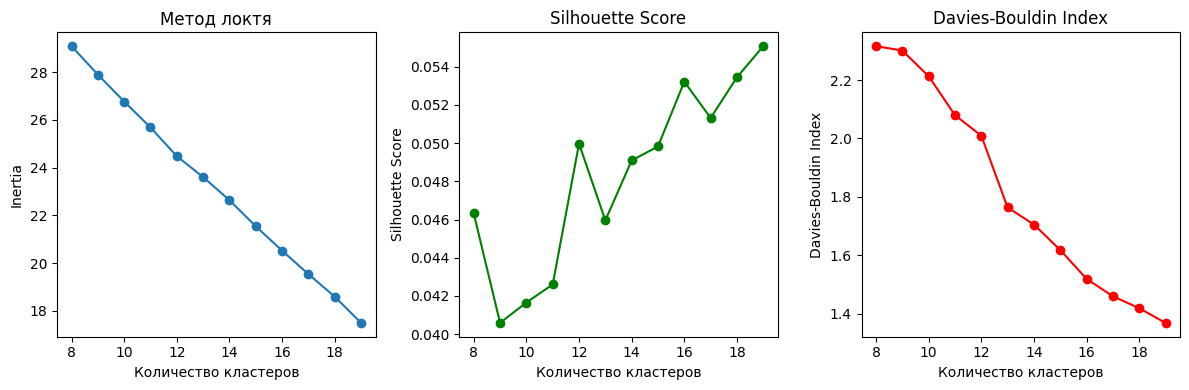

In [ ]:
# TF-IDF векторизация
vectorizer_test = TfidfVectorizer(max_df=0.4, min_df=5, stop_words=stopwords)  
X = vectorizer_test.fit_transform([" ".join(doc) for doc in tokenized_docs]) # список токенов тот же

clusters_range = range(8, 20, 1)
inertia = []
silhouette_scores = []
davies_bouldin_scores = []

for k in clusters_range:
    kmeans = KMeans(n_clusters=k, random_state=500, n_init=10)
    labels = kmeans.fit_predict(X)

    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, labels))
    davies_bouldin_scores.append(davies_bouldin_score(X.toarray(), labels))

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(clusters_range, inertia, marker='o')
plt.xlabel("Количество кластеров")
plt.ylabel("Inertia")
plt.title("Метод локтя")

plt.subplot(1, 3, 2)
plt.plot(clusters_range, silhouette_scores, marker='o', color='g')
plt.xlabel("Количество кластеров")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score")

plt.subplot(1, 3, 3)
plt.plot(clusters_range, davies_bouldin_scores, marker='o', color='r')
plt.xlabel("Количество кластеров")
plt.ylabel("Davies-Bouldin Index")
plt.title("Davies-Bouldin Index")

plt.tight_layout()
plt.show()

In [59]:
# смотрим ключевые слова кластеров при k тем
different_k_top_tfidf_keywords = {}
k_list = [8, 10, 12, 14, 16]

for num_clusters in k_list:
    kmeans = KMeans(n_clusters=num_clusters, random_state=100, n_init=10)
    kmeans.fit(X)

    terms = np.array(vectorizer_test.get_feature_names_out())
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

    each_cluster_keywords = {} # словарь для каждого k
    for i in range(num_clusters):
        top_words = ", ".join(terms[order_centroids[i, :10]])
        each_cluster_keywords[i] = top_words

    different_k_top_tfidf_keywords[num_clusters] = each_cluster_keywords
different_k_top_tfidf_keywords

{8: {0: '选手, 顾问, 玩家, 丧尸, 队友, 部长, 全职, 小队, 副本, 队长',
  1: '灵力, 掌门, 内丹, 魔族, 妖族, 魔气, 仙君, 死生, 苍穹, 宫主',
  2: '警察, 律师, 屏幕, 刑警, 警方, 司机, 外勤, 视频, 教室, 序列',
  3: '臣妾, 亲王, 嬷嬷, 奴家, 本宫, 太医, 太妃, 皇兄, 国公, 我道',
  4: '宗主, 宫主, 郎君, 尊上, 修士, 本尊, 护法, 掌门, 家主, 门生',
  5: '国师, 神官, 内丹, 骑兵, 修行者, 谷主, 鸾鸟, 师大, 信徒, 神座',
  6: '门主, 八荒, 神君, 阿娘, 丑八怪, 仙者, 魔王, 阿爹, 仙台, 小仙',
  7: '郡主, 戏子, 影视, 摄政王, 民众, 父王, 世子, 嬷嬷, 仆妇, 唱戏'},
 10: {0: '八荒, 小仙, 灵力, 神君, 阿娘, 仙者, 阿爹, 老君, 仙姑, 凡世',
  1: '警察, 刑警, 律师, 警方, 顾问, 外勤, 屏幕, 序列, 实习生, 司机',
  2: '宗主, 郎君, 尊上, 修士, 本尊, 护法, 家主, 门生, 新叶, 三界',
  3: '亲王, 奴家, 世子, 嬷嬷, 国公, 民众, 姨娘, 侯府, 仆妇, 本宫',
  4: '国师, 神官, 内丹, 谷主, 鸾鸟, 师大, 妖力, 花猫, 护法, 泡面',
  5: '臣妾, 嬷嬷, 太医, 我道, 本宫, 皇兄, 亲王, 太妃, 小太监, 妃嫔',
  6: '郡主, 戏子, 骑兵, 影视, 摄政王, 父王, 修行者, 嬷嬷, 唱戏, 班主',
  7: '宫主, 魔族, 苍穹, 掌门, 灵力, 百战, 魔剑, 簪花, 男主, 人界',
  8: '选手, 玩家, 教室, 屏幕, 老太爷, 团队, 事务所, 厕所, 爷爷奶奶, 服务员',
  9: '魔气, 掌门, 内丹, 门主, 妖族, 仙君, 死生, 魔王, 魔神, 丑八怪'},
 12: {0: '臣妾, 亲王, 嬷嬷, 奴家, 本宫, 太医, 皇兄, 我道, 大将军, 小太监',
  1: '魔气, 掌门, 门主, 仙君, 死生, 魔王, 魔神, 丑八怪, 宗师, 灵力',
  2: '顾问, 丧尸, 部长, 队友, 小队, 守护者, 

In [ ]:
# считаем когерентность для разных k
coherence_results = {}

# вычисление когерентности для каждого набора кластеров по разному числу кластеров
for k in different_k_top_tfidf_keywords.keys():
    topics = []  # сохраняем список тем в виде списка слов для каждого кластера
    clusters_keywords = different_k_top_tfidf_keywords[k]
    
    for cluster_id, top_words_str in clusters_keywords.items():
        # получаем список ключевых слов, разбивая строку по разделителю ", "
        topic_words = top_words_str.split(", ")
        topics.append(topic_words)

    coherence_model_cv = CoherenceModel(
        topics=topics,
        texts=tokenized_docs,
        dictionary=dictionary,
        coherence='c_v'
    )
    c_v = coherence_model_cv.get_coherence()
    
    coherence_model_npmi = CoherenceModel(
        topics=topics,
        texts=tokenized_docs,
        dictionary=dictionary,
        coherence='c_npmi'
    )
    c_npmi = coherence_model_npmi.get_coherence()
    
    coherence_results[k] = {"c_v": c_v, "c_npmi": c_npmi}
    # print(f"{k} кластеров: c_npmi = {c_npmi:.4f}, c_v = {c_v:.4f}")

# итоговый словарь
print("\nИтоговые показатели когерентности для различных k:")
for k, scores in coherence_results.items():
    print(f"Количество кластеров {k} -> {scores}")


Итоговые показатели когерентности для различных k:
Количество кластеров 8 -> {'c_v': 0.4133133305086081, 'c_npmi': -0.1120038263333687}
Количество кластеров 10 -> {'c_v': 0.4045234033681145, 'c_npmi': -0.13545110382497036}
Количество кластеров 12 -> {'c_v': 0.4059275018019836, 'c_npmi': -0.12298409112504738}
Количество кластеров 14 -> {'c_v': 0.48302902164256106, 'c_npmi': -0.08801677090805148}
Количество кластеров 16 -> {'c_v': 0.48611991308606933, 'c_npmi': -0.0837472221590514}


Кластеров 8: усреднённые c_npmi = -0.1102, усреднённые c_v = 0.4276
Кластеров 10: усреднённые c_npmi = -0.1152, усреднённые c_v = 0.4192
Кластеров 12: усреднённые c_npmi = -0.1217, усреднённые c_v = 0.3999
Кластеров 14: усреднённые c_npmi = -0.0909, усреднённые c_v = 0.4728
Кластеров 16: усреднённые c_npmi = -0.0748, усреднённые c_v = 0.4997
Кластеров 18: усреднённые c_npmi = -0.0824, усреднённые c_v = 0.4856
Кластеров 20: усреднённые c_npmi = -0.0652, усреднённые c_v = 0.5218
Кластеров 22: усреднённые c_npmi = -0.0658, усреднённые c_v = 0.5417


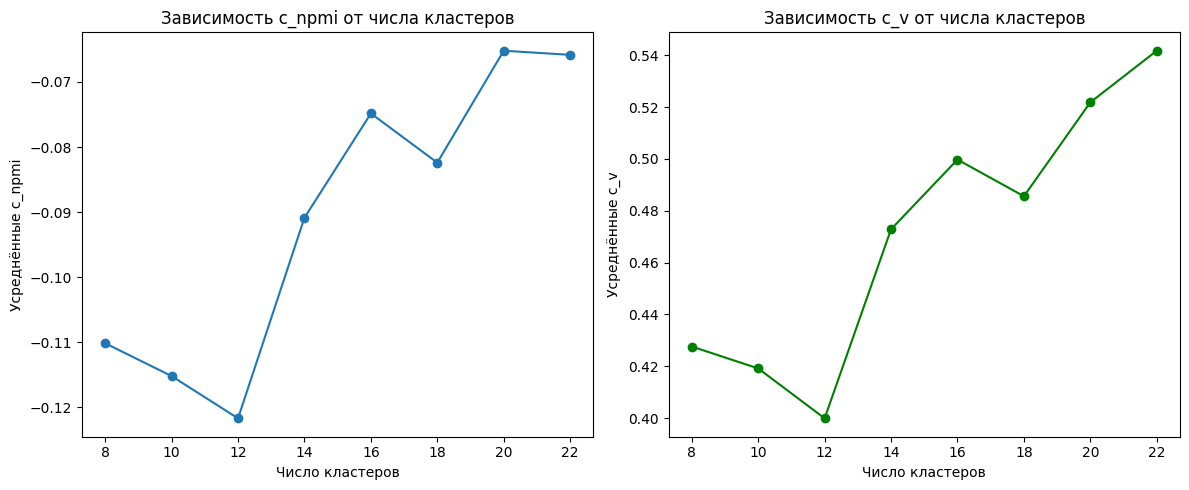

In [ ]:
# посчитаем зависимость УСРЕДНЕННЫХ метрик от кол-ва тем с разными random_state
clusters_range = [8, 10, 12, 14, 16, 18, 20, 22]
random_states = [42, 100, 500]

# словарь для хранения агрегированных значений метрик для каждого k
aggregated_results = {}

for k in clusters_range:
    # списки для накопления показателей для каждого random_state
    npmi_scores = []
    cv_scores = []
    
    for state in random_states:
        kmeans = KMeans(n_clusters=k, random_state=state, n_init=10)
        labels = kmeans.fit_predict(X)
        
        terms = np.array(vectorizer.get_feature_names_out())
        # получаем индексы слов в порядке убывания веса
        order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
        
        # извлекаем топ-10 слов для каждого кластера
        topics = []
        for i in range(k):
            top_words = [terms[idx] for idx in order_centroids[i, :10]]
            topics.append(top_words)
        
        # c_npmi для этих топовых слов
        coherence_model_npmi = CoherenceModel(
            topics=topics,
            texts=tokenized_docs,
            dictionary=dictionary,
            coherence='c_npmi'
        )
        current_npmi = coherence_model_npmi.get_coherence()
        npmi_scores.append(current_npmi)
        
        # и c_v для этих топовых слов
        coherence_model_cv = CoherenceModel(
            topics=topics,
            texts=tokenized_docs,
            dictionary=dictionary,
            coherence='c_v'
        )
        current_cv = coherence_model_cv.get_coherence()
        cv_scores.append(current_cv)
    
    # средние показатели показатели по всем random_state для k
    avg_npmi = np.mean(npmi_scores)
    avg_cv = np.mean(cv_scores)
    aggregated_results[k] = {'avg_c_npmi': avg_npmi, 'avg_c_v': avg_cv}
    print(f"Кластеров {k}: усреднённые c_npmi = {avg_npmi:.4f}, усреднённые c_v = {avg_cv:.4f}")

ks = list(aggregated_results.keys())
avg_npmi_vals = [aggregated_results[k]['avg_c_npmi'] for k in ks]
avg_cv_vals = [aggregated_results[k]['avg_c_v'] for k in ks]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(ks, avg_npmi_vals, marker='o')
plt.xlabel("Число кластеров")
plt.ylabel("Усреднённые c_npmi")
plt.title("Зависимость c_npmi от числа кластеров")

plt.subplot(1, 2, 2)
plt.plot(ks, avg_cv_vals, marker='o', color='g')
plt.xlabel("Число кластеров")
plt.ylabel("Усреднённые c_v")
plt.title("Зависимость c_v от числа кластеров")

plt.tight_layout()
plt.show()

# вывод: смотрим 8 или 10 кластеров
# но при 12 кластерах появляются новые темы!

## Работа с выбранными параметрами

In [ ]:
# # с нормализацией
# from sklearn.preprocessing import normalize
# from sklearn.cluster import KMeans

# num_clusters = 14
# docs_str = [" ".join(doc) for doc in tokenized_docs]
# kmeans_clusters = {} # словарь для записи центроидов

# vectorizer = TfidfVectorizer(max_df=0.4, min_df=5, stop_words=stopwords)  # игнорируем слишком частые/редкие слова
# X = vectorizer.fit_transform(docs_str)

# X_norm = normalize(X, norm='l2', axis=1)  # каждая строка нормируется до L2-единицы
# km_cos = KMeans(n_clusters=num_clusters, random_state=100, n_init=10)
# labels = km_cos.fit_predict(X_norm)

# cos_centroids = km_cos.cluster_centers_
# order_centroids_cos = cos_centroids.argsort()[:, ::-1]

# kmeans_cos_clusters = {}
# terms = np.array(vectorizer.get_feature_names_out())

# for i in range(num_clusters):
#     top_terms = terms[order_centroids_cos[i, :15]].tolist()
#     kmeans_cos_clusters[i] = top_terms

# for cluster_id, words in kmeans_cos_clusters.items():
#     print(f"Кластер {cluster_id}: {', '.join(words)}")

Кластер 0: 我道, 皇兄, 太医, 陪笑, 未语, 提步, 浣衣, 皇位, 塞外, 茶盅, 干吗, 儿臣, 这会子, 幽禁, 小太监
Кластер 1: 警察, 刑警, 顾问, 警方, 丧尸, 绑匪, 刑侦, 司机, 部长, 屏幕, 队友, 警车, 毒品, 嫌疑人, 民警
Кластер 2: 魔气, 掌门, 门主, 仙君, 死生, 魔王, 魔神, 丑八怪, 宗师, 灵力, 着墨, 修士, 屠神, 还阳, 五百年
Кластер 3: 宗主, 郎君, 尊上, 修士, 本尊, 护法, 家主, 门生, 新叶, 三界, 抹额, 野猪, 修真界, 掌门, 虐恋
Кластер 4: 国师, 神官, 骑兵, 修行者, 谷主, 鸾鸟, 师大, 信徒, 神座, 黑马, 湖畔, 原野, 老僧, 首座, 僧人
Кластер 5: 八荒, 小仙, 灵力, 神君, 阿娘, 仙者, 阿爹, 老君, 仙姑, 凡世, 仙台, 魔族, 上君, 女妖, 云头
Кластер 6: 亲王, 嬷嬷, 郡主, 奴家, 世子, 影视, 国公, 摄政王, 民众, 本宫, 姨娘, 父王, 仆妇, 太妃, 侯府
Кластер 7: 臣妾, 嬷嬷, 本宫, 太医, 太妃, 妃嫔, 秀女, 亲王, 嫔妃, 宫人, 小太监, 侍寝, 位分, 奏折, 荔枝
Кластер 8: 律师, 屏幕, 教室, 实习生, 老太爷, 视频, 电梯, 继母, 事务所, 海螺, 厕所, 爷爷奶奶, 服务员, 男生, 护士
Кластер 9: 戏子, 外勤, 判官, 妖族, 班主, 唱戏, 神木, 人族, 魔剑, 兜里, 天魔, 姐夫, 三千年, 千山, 饿死鬼
Кластер 10: 序列, 潜水, 占卜, 天使, 吊人, 特性, 女士, 造物主, 海盗, 配方, 单词, 信使, 晋升, 大帝, 值夜
Кластер 11: 选手, 玩家, 全职, 副本, 团队, 视角, 粉丝, 同人, 法师, 网吧, 穿云, 战术, 队长, 打法, 输出
Кластер 12: 宫主, 魔族, 苍穹, 掌门, 灵力, 百战, 魔剑, 簪花, 男主, 人界, 魔气, 谷主, 阴间, 灵兽, 峰峰
Кластер 13: 内丹, 妖族, 国师, 三重, 巨木, 神官, 花猫, 泡面, 老太, 哪想, 官兵, 内息, 堂主, 妖力, 教

In [ ]:
# преобразуем тексты в строки (у нас список токенов)
docs_str = [" ".join(doc) for doc in tokenized_docs]
kmeans_clusters = {} # словарь для записи центроидов

vectorizer = TfidfVectorizer(max_df=0.4, min_df=5, stop_words=stopwords)  
X = vectorizer.fit_transform(docs_str)

num_clusters = 14

kmeans = KMeans(n_clusters=num_clusters, random_state=100, n_init=10)
kmeans.fit(X)

terms = np.array(vectorizer.get_feature_names_out())
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

for i in range(num_clusters):
    # top_words = ', '.join(terms[order_centroids[i, :10]]) # это строки
    top_words = terms[order_centroids[i, :20]].tolist() # а нам нужен будет список
    kmeans_clusters[i] = top_words
print(kmeans_clusters)
    # print(f"Cluster {i}: {top_words}")

{0: ['我道', '皇兄', '太医', '陪笑', '未语', '提步', '浣衣', '皇位', '塞外', '茶盅', '干吗', '儿臣', '这会子', '幽禁', '小太监', '回京', '行去', '几案', '脸带', '监禁'], 1: ['警察', '刑警', '顾问', '警方', '丧尸', '绑匪', '刑侦', '司机', '部长', '屏幕', '队友', '警车', '毒品', '嫌疑人', '民警', '案件', '小队', '受害人', '病房', '小区'], 2: ['魔气', '掌门', '门主', '仙君', '死生', '魔王', '魔神', '丑八怪', '宗师', '灵力', '着墨', '修士', '屠神', '还阳', '五百年', '修真界', '烧纸', '祖母', '十大', '姨娘'], 3: ['宗主', '郎君', '尊上', '修士', '本尊', '护法', '家主', '门生', '新叶', '三界', '抹额', '野猪', '修真界', '掌门', '虐恋', '兰草', '真气', '冰晶', '灵力', '怨灵'], 4: ['国师', '神官', '骑兵', '修行者', '谷主', '鸾鸟', '师大', '信徒', '神座', '黑马', '湖畔', '原野', '老僧', '首座', '僧人', '方阵', '信道', '护法', '铁箭', '神武'], 5: ['八荒', '小仙', '灵力', '神君', '阿娘', '仙者', '阿爹', '老君', '仙姑', '凡世', '仙台', '魔族', '上君', '女妖', '云头', '上神', '尊上', '六界', '本上', '适才'], 6: ['亲王', '嬷嬷', '郡主', '奴家', '世子', '影视', '国公', '摄政王', '民众', '本宫', '姨娘', '父王', '仆妇', '太妃', '侯府', '李家', '太医', '兵丁', '父皇', '大将军'], 7: ['臣妾', '嬷嬷', '本宫', '太医', '太妃', '妃嫔', '秀女', '亲王', '嫔妃', '宫人', '小太监', '侍寝', '位分', '奏折', '荔枝', '秋千', '岂料', '恕罪', 

In [64]:
# with open('tfidf_result_all_tokens_k14_rs100.json', 'w', encoding='utf8') as file:
#     json.dump(kmeans_clusters, file, ensure_ascii=False)

In [49]:
# print(vectorizer.get_feature_names_out()[:50])  # первые 50 слов из словаря TF-IDF

# Ищем пересечения между LDA и TF-IDF

In [23]:
from collections import defaultdict

best_matches = {}

for lda_id, lda_words in lda_topics.items():
    lda_set = set(lda_words)
    best_match = None
    max_intersection = 0
    for kmeans_id, kmeans_words in kmeans_clusters.items():
        kmeans_set = set(kmeans_words)
        intersection = lda_set & kmeans_set
        if len(intersection) > max_intersection:
            max_intersection = len(intersection)
            best_match = {
                'kmeans_cluster': kmeans_id,
                'common_words': list(intersection),
                'overlap_count': len(intersection)
            }
    best_matches[lda_id] = best_match

In [24]:
best_matches

{0: {'kmeans_cluster': 3,
  'common_words': ['尊上',
   '修真界',
   '三界',
   '护法',
   '宗主',
   '虐恋',
   '掌门',
   '本尊',
   '新叶',
   '郎君'],
  'overlap_count': 10},
 1: {'kmeans_cluster': 2,
  'common_words': ['宗师', '仙君', '修士', '掌门', '着墨', '灵力', '死生'],
  'overlap_count': 7},
 2: {'kmeans_cluster': 10,
  'common_words': ['占卜',
   '造物主',
   '吊人',
   '大帝',
   '海盗',
   '女士',
   '单词',
   '潜水',
   '信使',
   '灵体',
   '特性',
   '天使',
   '晋升',
   '神灵',
   '序列',
   '配方',
   '值夜'],
  'overlap_count': 17},
 3: {'kmeans_cluster': 12,
  'common_words': ['谷主', '苍穹', '簪花', '掌门', '魔族', '铁索', '宫主', '灵兽', '灵力', '阴间'],
  'overlap_count': 10},
 4: {'kmeans_cluster': 10,
  'common_words': ['占卜',
   '造物主',
   '吊人',
   '海盗',
   '女士',
   '单词',
   '潜水',
   '魔女',
   '特性',
   '天使',
   '晋升',
   '神灵',
   '序列',
   '配方'],
  'overlap_count': 14},
 5: {'kmeans_cluster': 6,
  'common_words': ['兵丁', '太医', '仆妇', '民众', '世子'],
  'overlap_count': 5},
 6: {'kmeans_cluster': 4,
  'common_words': ['神座',
   '首座',
   '信徒',
   '原野',
   '国师

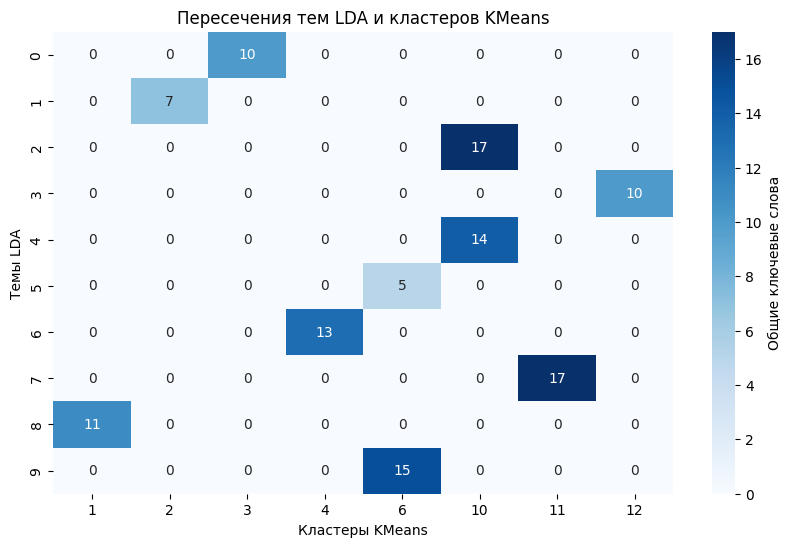

In [ ]:
# создаем таблицу пересечений
data = {}
for lda_id, match in best_matches.items():
    km_id = match['kmeans_cluster']
    overlap = match['overlap_count']
    data[(lda_id, km_id)] = overlap

df = pd.Series(data).unstack(fill_value=0)

plt.figure(figsize=(10, 6))
sns.heatmap(df, annot=True, cmap="Blues", cbar_kws={'label': 'Общие ключевые слова'})
plt.title("Пересечения тем LDA и кластеров KMeans")
plt.xlabel("Кластеры KMeans")
plt.ylabel("Темы LDA")
plt.show()

In [ ]:
combined_themes = []
for lda_id, match in best_matches.items():
    combined_themes.append({
        'topic_id': f'LDA {lda_id} + KMeans {match["kmeans_cluster"]}',
        'keywords': match['common_words'],
        'keyword_count': match['overlap_count'],
        'label': ''  # потом заполним названиями кластеров
    })
combined_themes

labels = {
    'LDA 0 + KMeans 3': 'Фэнтези-культы и мастера трёх миров',
    'LDA 1 + KMeans 2': 'Боевые культисты и бессмертные',
    'LDA 2 + KMeans 10': 'Мистицизм, последовательности и фракции',
    'LDA 3 + KMeans 12': 'Темное фэнтези: кланы и магия',
    'LDA 6 + KMeans 4': 'Религия и последователи',
    'LDA 7 + KMeans 11': 'Игровой мир и фан-культура',
    'LDA 8 + KMeans 1': 'Современные расследования',
    'LDA 9 + KMeans 6': 'Императорский двор и драмы',
}

# Проставляем названия
for theme in combined_themes:
    topic_id = theme['topic_id']
    if topic_id in labels:
        theme['label'] = labels[topic_id]

In [27]:
combined_themes

[{'topic_id': 'LDA 0 + KMeans 3',
  'keywords': ['尊上', '三界', '掌门', '护法', '修真界', '郎君', '新叶', '本尊', '宗主'],
  'keyword_count': 9,
  'label': 'Фэнтези-культы и мастера трёх миров'},
 {'topic_id': 'LDA 1 + KMeans 2',
  'keywords': ['仙君', '死生', '掌门', '灵力', '修士', '宗师'],
  'keyword_count': 6,
  'label': 'Боевые культисты и бессмертные'},
 {'topic_id': 'LDA 2 + KMeans 10',
  'keywords': ['潜水',
   '值夜',
   '海盗',
   '女士',
   '天使',
   '占卜',
   '序列',
   '配方',
   '单词',
   '特性',
   '晋升',
   '造物主',
   '吊人'],
  'keyword_count': 13,
  'label': 'Мистицизм, последовательности и фракции'},
 {'topic_id': 'LDA 3 + KMeans 12',
  'keywords': ['灵兽', '宫主', '魔族', '簪花', '掌门', '苍穹', '阴间', '灵力'],
  'keyword_count': 8,
  'label': 'Темное фэнтези: кланы и магия'},
 {'topic_id': 'LDA 4 + KMeans 10',
  'keywords': ['潜水', '海盗', '女士', '天使', '占卜', '序列', '配方', '特性', '造物主', '吊人'],
  'keyword_count': 10,
  'label': ''},
 {'topic_id': 'LDA 5 + KMeans 6',
  'keywords': ['仆妇', '世子', '民众'],
  'keyword_count': 3,
  'label': ''},
 

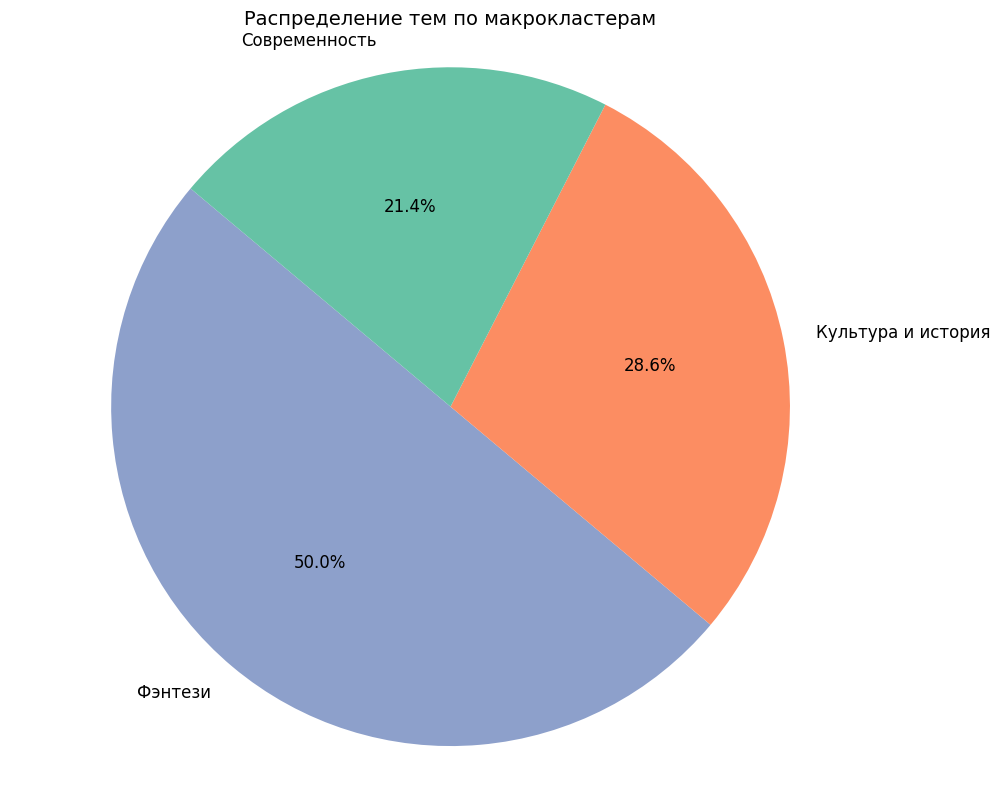

In [ ]:
import matplotlib.pyplot as plt

categories = ['Фэнтези', 'Культура и история', 'Современность']
counts = [7, 4, 3]

colors = ['#8da0cb', '#fc8d62', '#66c2a5']

plt.figure(figsize=(10, 8))
plt.pie(
    counts,
    labels=categories,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    textprops={'fontsize': 12}
)
plt.title('Распределение тем по макрокластерам', fontsize=14)
plt.axis('equal')  # сохраняем форму круга
plt.tight_layout()
plt.show()

# Валидация тем

### Китайские эмбеддинги

In [12]:
embedding_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

In [128]:
final_topics = {
    "1": ["占卜", "造物主", "吊人", "大帝", "海盗", "女士", "单词", "潜水", "信使", "灵体", "特性", "天使", "晋升", "神灵", "序列", "配方", "值夜"],
    "2": ["谷主", "苍穹", "簪花", "掌门", "魔族", "铁索", "宫主", "灵兽", "灵力", "阴间"],
    "3": ["神座", "首座", "信徒", "原野", "国师", "老僧", "神官", "湖畔", "黑马", "修行者", "铁箭", "僧人", "骑兵"],
    "4": ["记者", "法师", "穿云", "队长", "玩家", "同人", "团队", "网吧", "全职", "粉丝", "打法", "输出", "副本", "视角", "战术", "剑客", "选手"],
    "5": ["顾问", "司机", "丧尸", "刑警", "警方", "绑匪", "警察", "病房", "屏幕", "队友", "嫌疑人"],
    "6": ["国公", "本宫", "奴家", "太妃", "姨娘", "太医", "父皇", "李家", "侯府", "影视", "世子", "摄政王", "嬷嬷", "大将军", "亲王"],
    "7": ["宗师", "仙君", "修士", "掌门", "着墨", "灵力", "死生"],
    "8": ["尊上", "修真界", "三界", "护法", "宗主", "虐恋", "掌门", "本尊", "新叶", "郎君"],
    "9": ["民众", "仆妇", "世子", "施礼", "兵丁", "太医", "适才", "老大夫", "官兵", "花灯", "祖母", "少奶奶", "兵马", "内侍", "大老爷", "掌柜的", "山贼", "知府", "棋局", "杳"],
    "10": ["我道", "皇兄", "太医", "陪笑", "未语", "提步", "浣衣", "皇位", "塞外", "茶盅", "干吗", "儿臣", "这会子", "幽禁", "小太监", "回京", "行去", "几案", "脸带", "监禁"],
    "11": ["八荒", "小仙", "灵力", "神君", "阿娘", "仙者", "阿爹", "老君", "仙姑", "凡世", "仙台", "魔族", "上君", "女妖", "云头", "上神", "尊上", "六界", "本上", "适才"],
    "12": ["臣妾", "嬷嬷", "本宫", "太医", "太妃", "妃嫔", "秀女", "亲王", "嫔妃", "宫人", "小太监", "侍寝", "位分", "奏折", "荔枝", "秋千", "岂料", "恕罪", "难民", "香囊"],
    "13": ["律师", "屏幕", "教室", "实习生", "老太爷", "视频", "电梯", "继母", "事务所", "海螺", "厕所", "爷爷奶奶", "服务员", "男生", "护士", "助理", "班主任", "严师", "千山", "院长"],
    "14": ["戏子", "外勤", "判官", "妖族", "班主", "唱戏", "神木", "人族", "魔剑", "兜里", "天魔", "姐夫", "三千年", "千山", "饿死鬼", "族长", "角儿", "青铜", "小妖", "报纸"]
}

In [129]:
topic_embeddings = {}
for topic_id, kws in final_topics.items():
    topic_embeddings[topic_id] = embedding_model.encode(kws)

In [130]:
topic_embeddings

{'1': array([[ 0.08345893,  0.26246566, -0.04647061, ..., -0.03681695,
         -0.05628046,  0.09203624],
        [ 0.0198776 ,  0.20386459, -0.06640481, ..., -0.15354645,
          0.18741928,  0.16170178],
        [-0.04637022,  0.1432871 , -0.05411856, ..., -0.2479159 ,
         -0.07550367,  0.3060954 ],
        ...,
        [-0.11968255, -0.02599945, -0.03848238, ..., -0.05118102,
          0.1630722 , -0.08237474],
        [-0.10538317, -0.0783036 , -0.04559978, ...,  0.05679169,
          0.2405462 , -0.06260111],
        [ 0.27105242,  0.12018114,  0.1697013 , ...,  0.02112019,
         -0.12680489, -0.02939602]], dtype=float32),
 '2': array([[ 0.06789677,  0.15275906,  0.00442732, ..., -0.05899217,
          0.03432124,  0.06290141],
        [ 0.32178745,  0.30439797, -0.02999844, ..., -0.20272842,
         -0.18252315,  0.05453625],
        [ 0.03493905,  0.03146372,  0.04325808, ..., -0.03971777,
          0.13916147,  0.17575265],
        ...,
        [-0.07514083,  0.0398

### Эмбеддинги аннотаций

In [73]:
with open("stopwords-ru.txt", "r", encoding="utf8") as f:
    russian_stopwords = [line.strip() for line in f if line.strip()]

In [ ]:
morph_analyzer = pymorphy3.MorphAnalyzer()

def lemmatize_text_preserve_all(input_text):
    tokens = re.findall(r'\b[а-яА-ЯёЁ]+\b', input_text.lower())
    lemmas = [morph_analyzer.parse(token)[0].normal_form for token in tokens]
    return ' '.join(lemmas)

rake_extractor = Rake(stopwords=russian_stopwords, max_words=3)

input_folder_path = r"D:\Studies\HSE\project\annotations_without_NE"

extracted_keywords_by_file = {}

for file_name in os.listdir(input_folder_path):
    file_path = os.path.join(input_folder_path, file_name)

    with open(file_path, "r", encoding="utf8") as file:
        raw_text = file.read().strip().replace('\n', '')

    lemmatized_text = lemmatize_text_preserve_all(raw_text)

    rake_result = rake_extractor.apply(lemmatized_text)
    
    keyword_phrases = [phrase for phrase, score in rake_result[:20]]
    extracted_keywords_by_file[file_name] = keyword_phrases

print(extracted_keywords_by_file)

{'一级律师[星际].txt': ['закон оставаться неизменный', 'полгода спустя приходить', 'невезение наставник становиться', 'далёкий будущее', 'страстно желать', 'звезда погаснуть', 'покушение удаваться', 'двадцатилетний юноша', 'нелюбимый студент', 'неожиданный сотрудничество', 'появляться', 'технология', 'надежда', 'незнакомый', 'деньга', 'документ', 'множество', 'смерть', 'спасти', 'бывший'], '三生三世十里桃花 by 唐七公子.txt': ['наказание небожитель', 'сон богиня', 'спустя богиня', 'словно ветер', 'появляться надежда', 'сплетаться вновь', 'триста', 'разбить', 'сердце', 'разрушить', 'спрыгнуть', 'помост', 'смертный', 'забыть', 'принц', 'встретиться', 'безразличный', 'смочь', 'исправить'], '三生三世枕上书——唐七公子.txt': ['пытаться достигнуть недосягаемый', 'крошечный едва различимый', 'молчаливый упрямство обречь', 'вечный мука пожертвовать', 'судьба сулить крах', 'отражение неужели', 'единый шанс', 'сгущаться тень', 'оплатить кровь', 'настать черёд', 'готовый сражаться', 'прославить воин', 'сложный вернуть', 'судьба

In [ ]:
from summa import keywords as summa_keywords

test_file_path = r'D:\Studies\HSE\project\annotations_without_NE\苍兰诀.txt'

with open(test_file_path, "r", encoding="utf8") as f:
    test_text = f.read().strip().replace('\n', '')
    lemmatized_text = lemmatize_text(test_text, stopwords=russian_stopwords)

TR_keywords = summa_keywords.keywords(lemmatized_text, scores=True)
print(TR_keywords[:10])

[('фея', 0.329312536020947), ('повелитель демон', 0.26156527642510674), ('история', 0.21640440937358904), ('орхидея', 0.1875721916418276), ('башня решать воспользоваться наивный', 0.1395876262907167)]


In [124]:
from nlp_rake import Rake

def lemmatize(text):
    tokens = re.findall(r'\b[а-яА-ЯёЁ]+\b', text.lower())
    return ' '.join([morph.parse(token)[0].normal_form for token in tokens])

stopwords = russian_stopwords 
lemmatized_text = lemmatize(test_text)

rake = Rake(max_words=3)
rake_keywords = rake.apply(lemmatized_text)

print(rake_keywords[:10])

[('отомстить заклятый враг', 9.0), ('маленький орхидея вовсе', 9.0), ('готовый отчаянно сражаться', 9.0), ('взаимность бессердечный повелитель', 9.0), ('чаровать аромат орхидея', 9.0), ('большой демон ответить', 8.0), ('оказываться запереть', 4.0), ('демон', 2.0), ('простой', 1.0), ('свой', 1.0)]


In [125]:
# import yake

# # Создаем извлекатель ключевых слов
# kw_extractor = yake.KeywordExtractor(lan="ru", n=3, top=20)  # n=2 означает биграммы
# keywords = kw_extractor.extract_keywords(test_text)

# # Выводим результат
# for kw, score in keywords:
#     print(f"{kw} (score={score:.4f})")

In [27]:
# print(sum(annotations_tokens_amount))

In [126]:
annotations_keywords_embeddings = {}

for filename, keywords in annotations_keywords.items():
    annotation_keyword_embedding = embedding_model.encode(keywords)
    annotations_keywords_embeddings[filename] = annotation_keyword_embedding
# print(len(annotations_keywords_embeddings))
print(annotations_keywords_embeddings)

{'一级律师[星际].txt': array([[ 0.28872997,  0.3006952 , -0.12216482, ..., -0.5904078 ,
        -0.21638776,  0.16819228],
       [ 0.04595281,  0.26731715,  0.15555696, ..., -0.11710235,
        -0.07503235,  0.23318566],
       [ 0.03511783,  0.27163926, -0.24010731, ..., -0.1832736 ,
         0.10333639,  0.13375963],
       [ 0.01705469,  0.3915438 , -0.18262781, ..., -0.3978297 ,
         0.3564654 ,  0.1988503 ],
       [-0.03995932,  0.16087843,  0.05238725, ...,  0.0667976 ,
        -0.01221298,  0.11703291]], dtype=float32), '三生三世十里桃花 by 唐七公子.txt': array([[ 0.04340221,  0.32008266,  0.40854147, ..., -0.41652122,
        -0.2445261 ,  0.15598232],
       [ 0.12279501,  0.04504012, -0.02694127, ..., -0.25157502,
        -0.12235326, -0.24839485],
       [ 0.10100088,  0.12612885, -0.08274929, ..., -0.1871149 ,
         0.00855741,  0.05451529],
       [ 0.14080188,  0.00113257, -0.12068925, ..., -0.20770237,
        -0.17821921,  0.254848  ],
       [ 0.01575181,  0.05764236,  0.15244

In [127]:
from sklearn.metrics.pairwise import cosine_similarity

scores = {}

for annotation_filename, annotation_embedding in annotations_keywords_embeddings.items():
    topics_mean_topk = {}
    for topic_id, topic_embedding in topic_embeddings.items():
        # матрица косинусных сходств: строки — слова темы, столбцы — слова аннотации
        sim_matrix = cosine_similarity(topic_embedding, annotation_embedding)

        k = 5
        topk = np.sort(sim_matrix.flatten())[::-1][:k]
        mean_topk = topk.mean()
        topics_mean_topk[topic_id] = mean_topk
    topics_mean_topk_sorted = dict(sorted(topics_mean_topk.items(), key=lambda item: item[1], reverse=True))
    scores[annotation_filename] = topics_mean_topk_sorted

In [131]:
scores

{'一级律师[星际].txt': {'13': 0.70843995,
  '14': 0.6897559,
  '8': 0.68085957,
  '9': 0.67395175,
  '12': 0.6571579,
  '1': 0.65484154,
  '10': 0.6518028,
  '2': 0.6497332,
  '3': 0.646846,
  '6': 0.64131576,
  '11': 0.6371582,
  '4': 0.6266623,
  '5': 0.6049121,
  '7': 0.5924623},
 '三生三世十里桃花 by 唐七公子.txt': {'10': 0.78615034,
  '6': 0.76574886,
  '2': 0.75100595,
  '12': 0.7466339,
  '8': 0.7364791,
  '1': 0.7275218,
  '9': 0.7253319,
  '11': 0.72013754,
  '14': 0.71979684,
  '7': 0.71944875,
  '3': 0.6899207,
  '13': 0.6750521,
  '4': 0.6564288,
  '5': 0.6212608},
 '三生三世枕上书——唐七公子.txt': {'6': 0.812445,
  '10': 0.7858752,
  '12': 0.7611134,
  '8': 0.74511445,
  '2': 0.7440109,
  '1': 0.73681676,
  '3': 0.7225679,
  '14': 0.7165524,
  '9': 0.70422727,
  '7': 0.7009288,
  '13': 0.68943405,
  '11': 0.6887895,
  '4': 0.65878564,
  '5': 0.5976529},
 '二哈和他的白猫师尊.txt': {'2': 0.8252826,
  '6': 0.8190767,
  '14': 0.8151063,
  '8': 0.80591905,
  '10': 0.8046231,
  '3': 0.7869328,
  '1': 0.7853108,
  '9'

In [132]:
scores_df = pd.DataFrame.from_dict(scores, orient='index')

In [160]:
scores_df

11        12         7         5         1  \
一级律师[星际].txt          0.784668  0.677062  0.643337  0.637837  0.606493   
三生三世十里桃花 by 唐七公子.txt  0.645890  0.772509  0.651596  0.758603  0.805005   
三生三世枕上书——唐七公子.txt     0.644174  0.779977  0.603554  0.813730  0.813080   
二哈和他的白猫师尊.txt         0.672438  0.812817  0.681051  0.774088  0.809492   
人渣反派自救系统.txt          0.693807  0.843424  0.667882  0.809719  0.852405   
他来了请闭眼.txt            0.540360  0.639078  0.648340  0.665001  0.650019   
你是我的小确幸_御风九尧.txt      0.723670  0.748558  0.685220  0.704646  0.736930   
全职高手_蝴蝶蓝.txt          0.574135  0.660759  0.584688  0.705611  0.705844   
凰权_天下归元.txt           0.658030  0.783256  0.584575  0.783824  0.778887   
千秋.txt                0.643202  0.797381  0.652376  0.785699  0.811833   
后宫：甄嬛传1.txt           0.673208  0.782265  0.649870  0.730080  0.774929   
君九龄.txt               0.713376  0.849259  0.653839  0.838740  0.867412   
天官赐福.txt              0.685616  0.816277  0.611665  0.789735  0.828347   
嫡嫁千金.txt              0.669855  0.826547  0.589589  0.780619  0.821154   
将夜_猫腻【完结】.txt         0.634621  0.759637  0.632601  0.745629  0.767989   
延禧攻略.txt              0.716781  0.760252  0.605772  0.741075  0.758858   
恶魔少爷别吻我.txt           0.677480  0.839643  0.639235  0.782860  0.810944   
扶摇皇后.txt              0.622712  0.771436  0.562756  0.715013  0.759836   
护心.txt                0.640584  0.719702  0.595152  0.675370  0.702550   
招摇.txt                0.710191  0.848267  0.624748  0.749795  0.764809   
明天也喜欢.txt             0.624600  0.746909  0.605685  0.682387  0.717465   
朱颜.txt                0.659912  0.707727  0.633172  0.740348  0.753437   
步步惊心.txt              0.613882  0.689979  0.593520  0.742521  0.740538   
死亡万花筒.txt             0.674447  0.803451  0.587698  0.772789  0.805313   
烈火浇愁.txt              0.623407  0.715150  0.555020  0.659241  0.695334   
琉璃美人煞.txt             0.641795  0.760252  0.583272  0.739603  0.758540   
百界歌(百鬼集).txt          0.698098  0.861341  0.648222  0.818422  0.864211   
破云.txt                0.719806  0.811725  0.691833  0.779976  0.810871   
苍兰诀.txt               0.697175  0.826882  0.603194  0.792675  0.817120   
薄雾[无限].txt            0.672075  0.781357  0.650109  0.764168  0.784067   
诡秘之主_爱潜水的乌贼.txt       0.604694  0.706581  0.532629  0.731543  0.715001   
那片星空，那片海.txt          0.708357  0.842945  0.596239  0.795913  0.828917   
重生之将门毒后.txt           0.595540  0.686925  0.569930  0.715494  0.742010   
镇魂.txt                0.705124  0.856850  0.646666  0.803138  0.828243   
风月不相关.txt             0.605754  0.673927  0.535898  0.682105  0.709967   
香蜜沉沉烬如霜(香蜜2).txt      0.602255  0.687875  0.552506  0.692183  0.705240   
驭鲛记_九鹭非香.txt          0.669293  0.807906  0.612660  0.762939  0.802639   
鬓边不是海棠红.txt           0.710739  0.861759  0.674909  0.829527  0.868014   
魔尊也想知道.txt            0.620949  0.750422  0.569125  0.714988  0.730616   
魔道祖师.txt              0.685561  0.824909  0.623157  0.779626  0.794422   
黑月光拿稳BE剧本.txt         0.728858  0.887282  0.608399  0.840403  0.884946   
默读.txt                0.752850  0.819929  0.823218  0.755155  0.811735   

                             9        10         2         3         8  \
一级律师[星际].txt          0.604020  0.591582  0.587341  0.583024  0.578234   
三生三世十里桃花 by 唐七公子.txt  0.819356  0.813330  0.730047  0.739070  0.783327   
三生三世枕上书——唐七公子.txt     0.802692  0.817677  0.770933  0.709172  0.840361   
二哈和他的白猫师尊.txt         0.765904  0.823728  0.749976  0.731825  0.775090   
人渣反派自救系统.txt          0.839854  0.855194  0.786416  0.775314  0.813849   
他来了请闭眼.txt            0.693576  0.661216  0.692404  0.622640  0.596602   
你是我的小确幸_御风九尧.txt      0.733296  0.751427  0.711605  0.724428  0.706301   
全职高手_蝴蝶蓝.txt          0.667217  0.670140  0.654973  0.609851  0.657317   
凰权_天下归元.txt           0.786154  0.840912  0.763392  0.745033  0.800662   
千秋.txt                0.773562  0.798843  0.766518  0.760257  0.790709   
后宫：甄嬛传1.txt           0.765903 

C:\Users\soule\AppData\Local\Temp\ipykernel_21232\83828718.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([scores_df[col] for col in scores_df.columns], labels=scores_df.columns, showfliers=True)


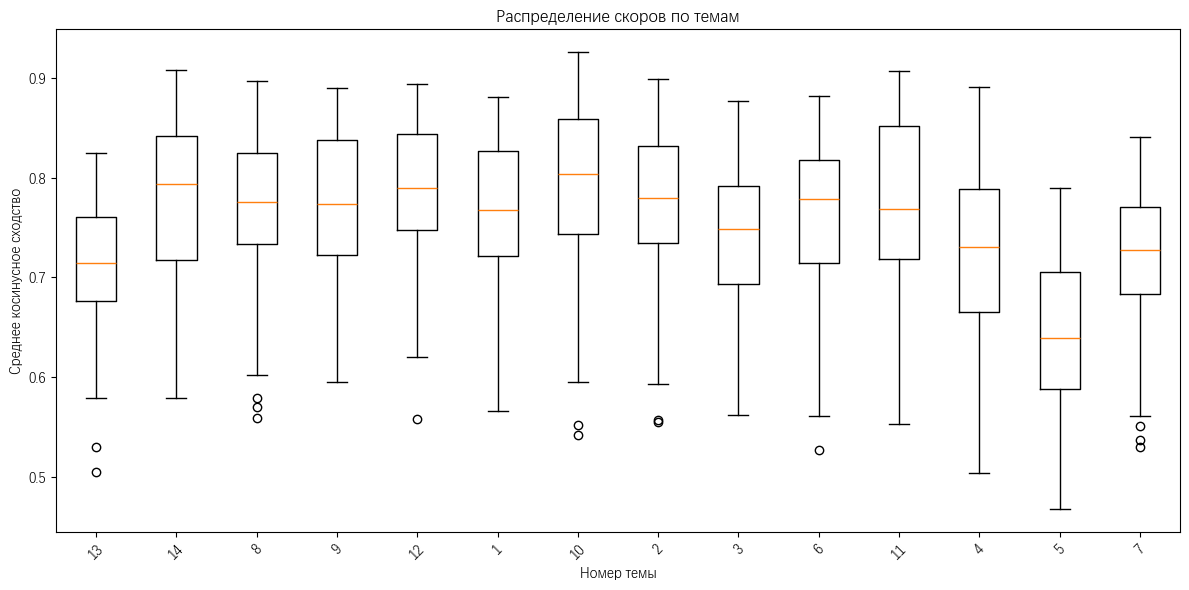

In [133]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.boxplot([scores_df[col] for col in scores_df.columns], labels=scores_df.columns, showfliers=True)
plt.xlabel("Номер темы")
plt.ylabel("Среднее косинусное сходство")
plt.title("Распределение скоров по темам")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [134]:
outliers = []

for topic in scores_df.columns:
    q1 = scores_df[topic].quantile(0.25)
    q3 = scores_df[topic].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr

    topic_outliers = scores_df[scores_df[theme] < lower_bound]
    for novel, score in topic_outliers[theme].items():
        outliers.append({
            'Novel': novel,
            'Theme': topic,
            'Similarity': score
        })

outliers_df = pd.DataFrame(outliers)
outliers_df

Novel Theme  Similarity
0       嫡嫁千金.txt    13    0.529553
1       烈火浇愁.txt    13    0.550411
2     薄雾[无限].txt    13    0.537203
3       嫡嫁千金.txt    14    0.529553
4   一级律师[星际].txt     8    0.592462
5       嫡嫁千金.txt     8    0.529553
6       烈火浇愁.txt     8    0.550411
7     薄雾[无限].txt     8    0.537203
8         镇魂.txt     8    0.561236
9       嫡嫁千金.txt     9    0.529553
10    薄雾[无限].txt     9    0.537203
11  一级律师[星际].txt    12    0.592462
12      嫡嫁千金.txt    12    0.529553
13      烈火浇愁.txt    12    0.550411
14    薄雾[无限].txt    12    0.537203
15        镇魂.txt    12    0.561236
16      嫡嫁千金.txt     1    0.529553
17      烈火浇愁.txt     1    0.550411
18    薄雾[无限].txt     1    0.537203
19        镇魂.txt     1    0.561236
20      嫡嫁千金.txt    10    0.529553
21      烈火浇愁.txt    10    0.550411
22    薄雾[无限].txt    10    0.537203
23        镇魂.txt    10    0.561236
24      嫡嫁千金.txt     2    0.529553
25      烈火浇愁.txt     2    0.550411
26    薄雾[无限].txt     2    0.537203
27        镇魂.txt     2    0.561236
28      嫡嫁千金.txt     3    0.529553
29    薄雾[无限].txt     3    0.537203
30      嫡嫁千金.txt     6    0.529553
31      烈火浇愁.txt     6    0.550411
32    薄雾[无限].txt     6    0.537203
33      嫡嫁千金.txt     7    0.529553
34      烈火浇愁.txt     7    0.550411
35    薄雾[无限].txt     7    0.537203

C:\Users\soule\AppData\Local\Temp\ipykernel_21232\2971723628.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=median_scores.index, y=median_scores.values, palette="viridis")


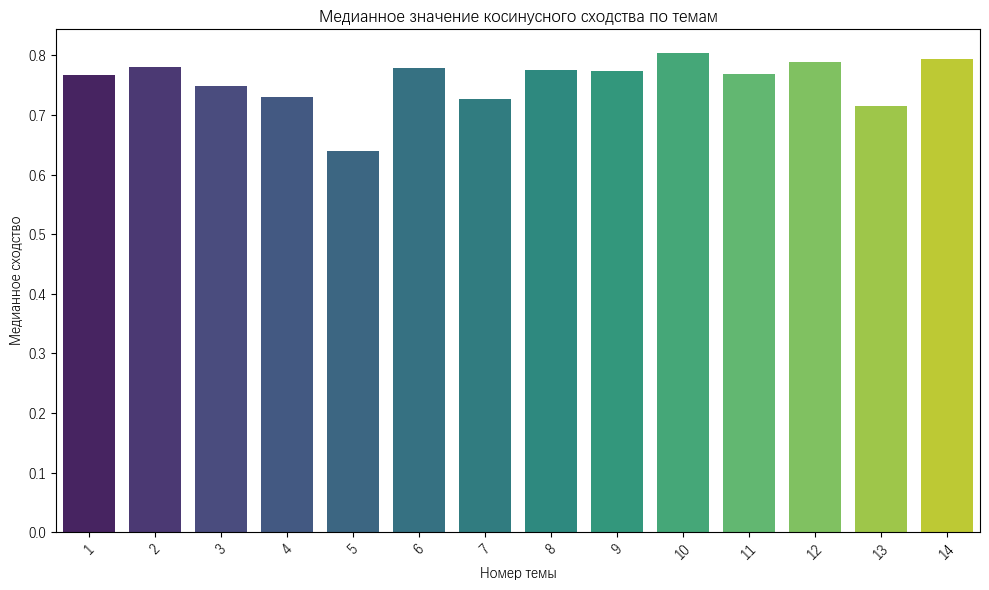

In [ ]:
# насколько хорошо тема совпадает (в среднем) с аннотациями разных произведений
records = []

for novel, topics in scores.items():
    for topic_id, similarity in topics.items():
        records.append({
            "Novel": novel,
            "Topic": int(topic_id),       
            "Similarity": float(similarity)
        })

df = pd.DataFrame(records)

# print(df.head(10))

median_scores = df.groupby("Topic")["Similarity"].median().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=median_scores.index, y=median_scores.values, palette="viridis")
plt.title("Медианное значение косинусного сходства по темам")
plt.xlabel("Номер темы")
plt.ylabel("Медианное сходство")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\soule\AppData\Local\Temp\ipykernel_21232\4209014653.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_df["Theme"].astype(str), y=top_df["Similarity"], palette="pastel")


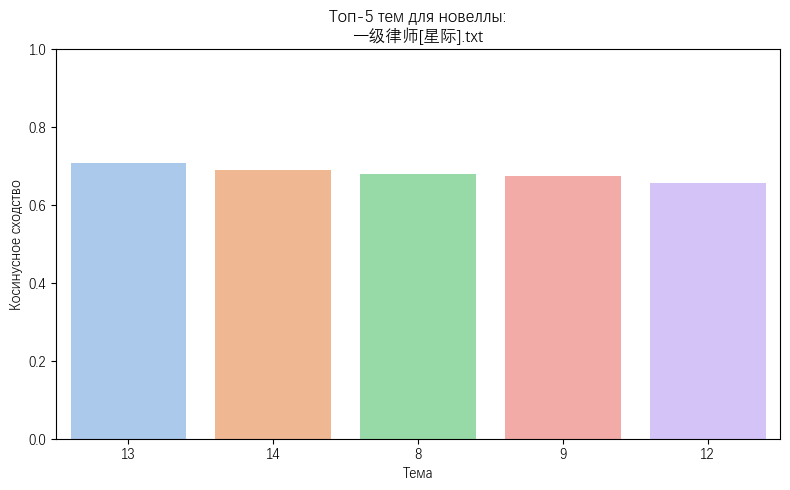

In [108]:
plt.rcParams['font.family'] = 'DengXian'  
plt.rcParams['axes.unicode_minus'] = False

# какие темы наиболее подходят для описания конкретной аннотации
example_novel = "一级律师[星际].txt"
top_n = 5

# строки только для одной новеллы
example_df = df[df["Novel"] == example_novel].sort_values(by="Similarity", ascending=False)

# топ-N тем
top_df = example_df.head(top_n)

plt.figure(figsize=(8, 5))
sns.barplot(x=top_df["Theme"].astype(str), y=top_df["Similarity"], palette="pastel")
plt.title(f"Топ-{top_n} тем для новеллы:\n{example_novel}")
plt.xlabel("Тема")
plt.ylabel("Косинусное сходство")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [ ]:
threshold = 0.7

# число попаданий по темам
hits = {}
total_docs = len(scores)
for doc, topics in scores.items():
    for topic, score in topics.items():
        if score >= threshold:
            hits[topic] = hits.get(topic, 0) + 1

sorted_hits = sorted(hits.items(), key=lambda x: x[1], reverse=True)

# доли
topic_threshold_results = [
    (topic, count, count/total_docs * 100)
    for topic, count in sorted_hits
]

In [52]:
topic_threshold_results

[('2', 34, 80.95238095238095),
 ('9', 34, 80.95238095238095),
 ('10', 33, 78.57142857142857),
 ('12', 33, 78.57142857142857),
 ('8', 33, 78.57142857142857),
 ('1', 33, 78.57142857142857),
 ('6', 32, 76.19047619047619),
 ('11', 32, 76.19047619047619),
 ('14', 32, 76.19047619047619),
 ('3', 31, 73.80952380952381),
 ('4', 27, 64.28571428571429),
 ('13', 26, 61.904761904761905),
 ('7', 26, 61.904761904761905),
 ('5', 12, 28.57142857142857)]

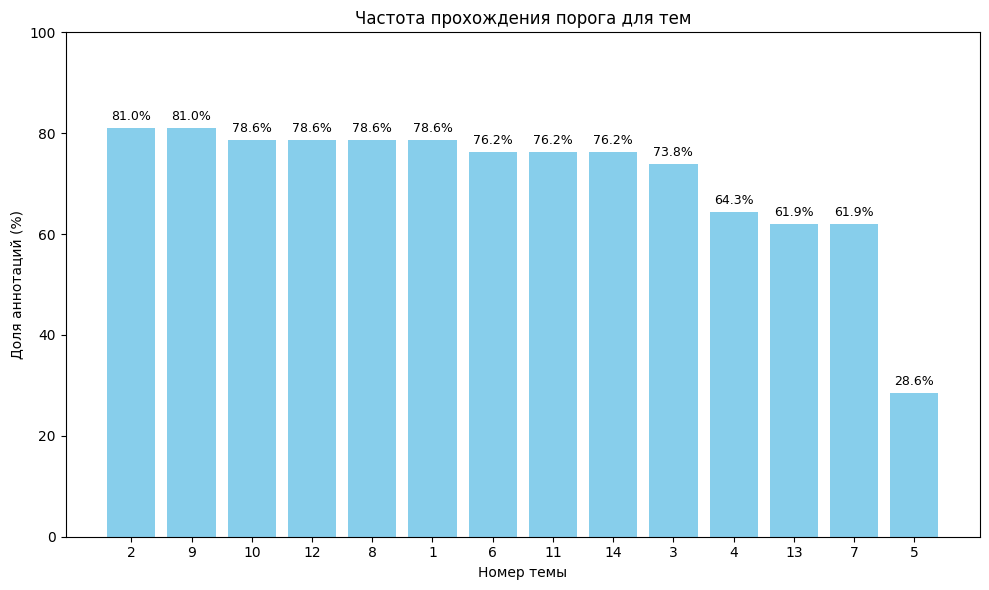

In [ ]:
total_docs = 42

topics, counts, percentages = zip(*topic_threshold_results)

plt.figure(figsize=(10, 6))
bars = plt.bar(topics, percentages, color='skyblue')
plt.xlabel('Номер темы')
plt.ylabel('Доля аннотаций (%)')
plt.title('Частота прохождения порога для тем')
plt.ylim(0, 100)

for bar, perc in zip(bars, percentages):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 1,
        f'{perc:.1f}%',
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.tight_layout()
plt.show()

# NMF

In [10]:
%pip install turftopic

  Using cached igraph-0.11.8-cp39-abi3-win_amd64.whl.metadata (3.9 kB)
  Using cached pillow-10.4.0-cp311-cp311-win_amd64.whl.metadata (9.3 kB)
  Using cached texttable-1.7.0-py2.py3-none-any.whl.metadata (9.8 kB)
Using cached igraph-0.11.8-cp39-abi3-win_amd64.whl (2.0 MB)
Using cached pillow-10.4.0-cp311-cp311-win_amd64.whl (2.6 MB)
Using cached texttable-1.7.0-py2.py3-none-any.whl (10 kB)
  Attempting uninstall: pillow
    Found existing installation: pillow 10.3.0
    Uninstalling pillow-10.3.0:
      Successfully uninstalled pillow-10.3.0
Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [34]:
from turftopic.vectorizers.chinese import ChineseCountVectorizer
from sentence_transformers import SentenceTransformer
from turftopic import KeyNMF

In [69]:
nmf_vectorizer = ChineseCountVectorizer(stop_words=stopwords) # завязан на статистику, выделяет темы на основе частотности
nmf_encoder = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2") # семантические представления слов

D:\python\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [25]:
nmf_model = KeyNMF(
    n_components=12,
    top_n=15,
    vectorizer=nmf_vectorizer, # внутренний токенизатор здесь бьет NE лучше, чем в первой обработке!!!
    encoder=nmf_encoder,
    random_state=100, 
)

In [36]:
# корпус почти без предобработки, только с удаленной латиницей, но со знаками препинания!
folder_path = r"D:\Studies\HSE\project\texts_without_NE"
corpus = []

for filename in os.listdir(folder_path):
  with open(os.path.join(folder_path, filename), "r", encoding="utf8") as file:
    text = file.read()
    filtered_text = remove_latin_symbols(text)
  corpus.append(filtered_text)

In [37]:
print(corpus[:1])

["十一月末，的初冬，中央传来例行的早钟，灰鸽拍着翅膀从同样灰霾的天空掠过。阴沉、寒冷、丧气冲天。多好的日子，适合打家劫舍给人送终，很衬燕绥之此刻的心情。几个前，他还顶着一级律师的头衔，担任着星际大学院长一职，衣冠楚楚参加着名流聚集的花园酒会呢……这才多久，就变得一贫如洗了。这会儿是早上点，他走在西部最混乱的市区，一边缓缓喝着咖啡，一边扫视着街边商店拥挤的标牌。他的脸素白好看，神情却透着浓重的不爽与嫌弃，仿佛喝的不是精磨咖啡，而是纯正屎。他在这里转了半天，就是找一家合适的店——能帮忙查点，最好还能办张假证。五分钟后，之在一家窄小的门店前停了脚步。这家门店外的电子标牌上显示着两行字——黑石维修行什么都干！很好。之捏了咖啡杯，丢进街边的电子回收箱，抬脚进了这家店。“早上好——”老板顶着鸡窝头从柜台后面探出脑袋，“有什么需要帮忙的？”店里暖气很足，即便是现在有点怕冷的之也感受到了暖意。他了黑色手套，从大衣口袋里掏出一枚金属环搁在柜台上，“帮我查一下这个。”这是可塑式智能机，能随意变形，大多数人都更习惯环形，方便携带。手环、指环、耳环……甚至脚环、腰环。之口味没那么，所以他手里的这枚就是个很素的指环。“查什么？”“所有能查的。”“好嘞。”老板配适好工具，叩了两下，智能机弹出了全息界面。界面里的少得可怜，干净得就像是出厂。总共就四样内容：一份身份证明，一张资产卡，一趟去邻星的飞梭机票，以及一段电子合成的音频文件。出于职业道德，老板不会随便翻看文件，但是之却对这四样的内容清清楚楚，毕竟这两天他已经翻来覆去看了几十遍——身份证明是个临时的假身份，名字叫，大学毕业，屁事不会；资产卡是黑市搞来的不记名虚拟卡，余额不够他活俩；飞梭机票只有去程，没有返程，大意是让他能滚多远滚多远。“就这些？”老板问。之心里就是一声冷笑：“是啊，就这些。”何止智能机里就这些，他眼下的全部家当恐怕也就是这些了。你说这刺不刺激？他不过是在五月的周末参加了一个酒会而已……那天的酒温略有些低，过半巡就刺得他胃不舒服，于是他跟众人打了声招呼先行离开，就近找了家酒店休息。谁知那一觉“睡”了整整半年，从夏睡到了冬，再睁眼已经是十一月了，也就是两天前。他醒在一间市区的公寓里，醒来的时候枕边就放着这只智能机，除此以外，一无所有。好在网上的信息五花八门，他没费什么功夫就弄清了表面的原委——酒会那天，他下榻的酒店刚巧发生了袭击

In [26]:
# # корпус, склеенный из обработанных токенов - хуже, чем цельный
# joined_corpus = ["".join(doc) for doc in tokenized_docs]
# len(joined_corpus)

42

In [27]:
# # проверка
# for i in joined_corpus:
#     if "魏无羡" in i:
#         print(i)
#         break

死大快人心围剿刚刚结束未及第二日消息插翅飞遍整个修真界当初战火蔓延速度有过之而无不及一时之间无论是世家名门山野散修议论四大玄门世家联率大小百家参与混战围剿行动好好大快人心手刃老祖哪位名士英豪师弟宗主江氏金氏蓝氏聂氏四大家族打头阵大义灭亲老巢一锅端句公道话杀得立即抚掌亮声应杀得江氏收养栽培这辈子混迹乡野市井庸徒谈原先宗主亲儿子养倒好公然叛逃百家敌丢江氏脸害得几乎满门惨死忘恩负义白眼狼就让这厮嚣张这么久换当初某人叛逃捅一刀清理门户机会做出后来丧心病狂之事讲同门同修青梅竹马情面修炼邪术遭受反噬受手下鬼撕咬蚕食死听说活活咬碎齑粉哈哈哈哈现世报早就养那批鬼一群拴疯狗到处咬人咬死活该话虽如此围剿宗主老祖弱点拟定计划成功难说别忘了手上当初晚上三千多成名修士全军覆没五千三千五千差不多五千丧心病狂死毁掉阴虎符算积阴德留下那鬼贻害人间更加罪孽深重阴虎符三字一出一阵静默顾忌片刻一人慨叹要说这魏当年之中极富盛名世家公子并非不曾有过佳迹年少成名何等风光恣意究竟走到一步话题转移议论声纷纷然修炼终归是非正统路子不可邪魔歪道一时风光无限嚣张了不起下场掷地有声死无全尸不全是修炼之道害归根结底此人人品差天怒人怨所谓善恶终有报天道身死盖棺定论所论内容大同小异偶有微弱异声压下去每个心头一缕阴霾挥之不去老祖已身死事成之后召唤残魂魂魄也许鬼吞噬一同分食也许逃逸自然皆大欢喜普天同庆老祖翻天灭地移山倒海之能至少传闻中抗拒召魂难事他来日元复位夺舍重生届时玄门百家整个人间必将迎来更加丧心病狂报复诅咒陷入腥风血雨之中一百二十座镇山石兽压在顶后大家族进行频繁召魂仪式严查夺舍搜集各地异象全力警戒第一年风平浪静第二年风平浪静第三年风平浪静第十三依然风平浪静至此越来越相信也许了不起也许神魂俱灭曾经翻手为云覆手终归一日成为翻覆人会永远奉神坛之上传说仅仅只是传说作者有话要说夶夶久等这篇文实在卡厉害三次情况拖久接受殴打抱头主主受逆з∠看上去人品糟糕相信主角人品差劲渣反不太一篇希望喜欢喜欢勉强哈哈哈哈魏无羡刚睁开眼睛踹一脚一道惊雷炸耳边装死胸一脚踹几欲吐血后脑仰面朝天朦胧敢踹老祖胆子不小活人说话响亮叫骂头昏眼花年轻公鸭嗓在耳鸣回荡想想住谁家谁家米谁家几样本来四周传来翻箱倒柜摔天砸哐当之声半晌双眼渐渐清明视线浮出昏暗屋顶一张眉梢吊眼珠发绿脸孔正在上方唾沫横飞敢告状怕告家里会为做主一旁围过来家仆模样壮汉公子砸完公鸭嗓少年家仆这破屋子本来公

In [62]:
document_topic_matrix = nmf_model.fit_transform(corpus)

⠋ Decomposing with NMF

           Model fitting done.                                                                        ]8;id=420651;file://D:\python\Lib\site-packages\turftopic\models\keynmf.py\keynmf.py]8;;\:]8;id=280746;file://D:\python\Lib\site-packages\turftopic\models\keynmf.py#235\235]8;;\

In [63]:
nmf_model.print_topics()

┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Topic ID ┃ Highest Ranking                                                                                      ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        0 │ 熙熙攘攘, 忧国忧民, 假山, 凶多吉少, 刀山火海, 芸芸众生, 何家道, 殷湛夏, 国锡叉疆国, 洛湘府           │
├──────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────┤
│        1 │ 山盟海誓, 颐指气使, 熙熙攘攘, 假山, 秋江秋江, 艳阳高照, 贵坂田, 杨宝梨道, 蒋梦萍程, 李天瑶光         │
├──────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────┤
│        2 │ 灯下, 黑灯瞎火, 幽光, 灯架, 照亮, 照明, 长明灯, 漆之光, 暮霭, 如灯                                   │
├──────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────┤
│        3 │ 山盟海誓, 魏无羡沙, 完江澄道, 尸江澄道, 魏无羡拉江厌, 瑶道免, 善江澄道, 孟瑶道, 瑶使, 教江澄怒       │
├──────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────┤
│        4 │ 凶多吉少, 昏昏沉沉, 鬼鬼祟祟, 故弄玄虚, 飘飘忽忽, 语不惊人死不休, 扑朔迷离, 必诛栖云, 躲躲闪闪,      │
│          │ 迷迷糊糊                                                                                             │
├──────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────┤
│        5 │ 假山, 弱柳扶风, 大马金刀, 凶多吉少, 烈日炎炎, 久负盛名, 陌少道, 聂初寅道, 叶小侯尚, 陌叶道           │
├──────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────┤
│        6 │ 碎尸万段, 生死未卜, 死气沉沉, 生死存亡, 同生共死, 生死与共, 妖连死, 宣骄死, 尸横遍野, 奄奄一息       │
├──────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────┤
│        7 │ 风声鹤唳, 波涛汹涌, 狂啸, 暗潮汹涌, 暴跳如雷, 狂风骤雨, 爆裂声, 硝烟弥漫, 天崩地裂, 狂风暴雨         │
├──────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────┤
│        8 │ 荒山野岭, 地燃垩烧, 火秋烟, 火云般, 出火凤鸣啸, 丛山峻岭, 寒潭畔, 幽绿细藤, 随斩莫山山, 遮星国       │
├──────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────┤
│        9 │ 萧家萌, 妈美人, 妈会, 萧蔷萌, 我芳芳姐, 江妈萌, 温柔体贴, 当妈身, 芳芳姐, 爸萧母                     │
├──────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────┤
│       10 │ 熙熙攘攘, 刀山火海, 魏清巍道, 烈日炎炎, 沙灰道, 君纱华铃爹, 养兵千日, 淫词艳曲, 岳七抱, 趁仙盟       │
├──────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────┤
│       11 │ 天昏地暗, 和风细雨, 呼风唤雨, 翻云覆雨, 腥风血雨, 连谷雨, 风吹雨打, 谷雨气, 暗流, 贴谷雨             │
├──────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────┤
│       12 │ 繁华区, 城市贫民, 商圈, 闹市区, 满大街, 城区, 市郊, 全市, 城郊, 招摇过市                             │
├──────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────┤
│       13 │ 明晚, 熬夜, 明早, 我夜, 晚总好, 彻夜未眠, 过夜, 除夕之夜, 一夜, 几晚                                 │
└──────────┴──────────────────────────────────────────────────────────────────────────────────────────────────────┘